Tutorial for Photon-Limited Deblurring dataset proposed in the paper ["Photon Limited Non-Blind Deblurring using Algorithm Unrolling"](https://arxiv.org/pdf/2110.15314.pdf). In this tutorial, we introduce the photon-limited deblurring dataset which consists of raw sensor values of photon-limited blurred images, the corresponding blur kernels and the ground truths.

The images in this dataset are in raw sensor values unlike traditional datasets with RGB images in compressod form. Therefore, we walk you through how to load the images, reconstruct them using our method and evaluate them using the ground-truth.

First we load the images, with index 14, and the corresponding blur kernel. The image is in Bayer format (RGGB) and blurred with camera motion and corrupted with photon shot noise since it was taken in a scene with low-illumination.

(-0.5, 64.5, 64.5, -0.5)

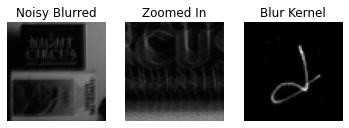

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils_deblur import pad

DATA_DIR = 'data/real_data/'
IDX = 14

# Load data-files
y = np.load(DATA_DIR+'lux5/cut'+str(IDX)+'.npy')     # Noisy-blurred Bayer-pattern image 
k = np.load(DATA_DIR+'lux5/kernel'+str(IDX)+'.npy')  # blur kernel
# Clipping negative values of 'y' and 'k' and normalize entries of 'k' to 1
y = np.clip(y.astype(np.float32),0,np.inf); k = np.clip(k.astype(np.float32),0,np.inf)
k /= np.sum(np.ravel(k))
k = pad(k , [65,65])

# Visualize the images
plt.subplot(1,3,1); plt.imshow(y,cmap='gray'); plt.title('Noisy Blurred'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(y[400:800, 600:1000],cmap='gray'); plt.title('Zoomed In'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(k,cmap='gray'); plt.title('Blur Kernel'); plt.axis('off')

Next, we load our non-blind solver P4IP_Net which can deblur noisy and blurred image. We take the raw Bayer pattern image in the variable 'y' and separate it out into 4 channels - R, G1, G2, B. The photon level for each channel is estimated separately using a heuristic.

In [2]:
import torch
from models.network_p4ip import P4IP_Net

# Load the network
MODEL_FILE = 'model_zoo/p4ip_100epoch.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p4ip = P4IP_Net(); p4ip.load_state_dict(torch.load(MODEL_FILE)); 
p4ip.to(device); p4ip.eval()

# Convert Bayer-pattern images to list of grayscales images
# R, G1, G2, B - 4 channels which togethor constitute the Bayer image
y_list = []
y_list.append(y[0::2, 0::2])
y_list.append(y[0::2, 1::2])
y_list.append(y[1::2, 0::2])
y_list.append(y[1::2, 1::2])
H, W = np.shape(y)

# Evaluate photon-levels for each channel using the heuristic used in [1]
M_list = []
for y in y_list:
    M_hat = np.mean(np.ravel(y))/0.33
    M_list.append(M_hat)

In this step, each channel is restored by the wrapper function _p4ip_wrapper_pad_ - which pads the input image _y_ symmetrically, passes it through the network and then returns the cropped out version of the output.

In [3]:
from utils.utils_test import p4ip_wrapper_pad

rggb_list = []
for y, M in zip(y_list, M_list):
    # Slightly time consuming step 
    x_rec = p4ip_wrapper_pad(y, k, M, p4ip)
    rggb_list.append(x_rec*M)

Since, we have the reconstructed outputs for each channel, we combine them into a single RGB image using demosaicing - followed by gray world white-balancing (making sure mean of each channel is the same).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 499.5, 499.5, -0.5)

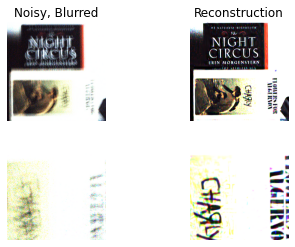

In [6]:
from utils.utils_test import rggb_to_rgb, gray_world_whitebalance
    
MODE = 'BGGR' if IDX in [15,20,24] else 'RGGB'
x_p4ip = rggb_to_rgb(rggb_list, H, W, MODE); x_p4ip = gray_world_whitebalance(x_p4ip)
y = rggb_to_rgb(y_list, H, W, MODE); y = gray_world_whitebalance(y)


plt.subplot(2,2,1); plt.imshow(y, vmin=np.min(y), vmax=np.max(y)); plt.title('Noisy, Blurred'); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(x_p4ip, vmin=np.min(y), vmax=np.max(y)); plt.title('Reconstruction'); plt.axis('off')

H1, H2, W1, W2 = 800, 1300, 800, 1300
plt.subplot(2,2,3); plt.imshow(y[H1:H2, W1:W2,:], vmin=np.min(y), vmax=np.max(y)) 
plt.axis('off')
plt.subplot(2,2,4); plt.imshow(x_p4ip[H1:H2, W1:W2,:], vmin=np.min(y), vmax=np.max(y))
plt.axis('off')

To evaluate our result, we use the ground-truth image but with few extra steps.
1. We need to register the ground-truth image to our reconstruction since the two were taken with different cmaera positions
2. Once the images are regsitered to each other, we ensure that both images have the same whitebalance before we evaluate our reconstruction scheme using PSNR and SSIM.  

PSNR: 28.37, SSIM: 0.732


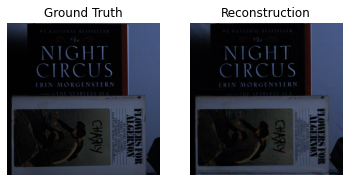

In [8]:
from utils.utils_test import img_register
from skimage.metrics import structural_similarity as ssim
import cv2 as cv2
# Load images in CV2 format for image registration and comparison
IDX_CLEAN = int(IDX/3)
x_gt = cv2.imread(DATA_DIR+'lux5_clean/'+str(IDX_CLEAN)+'.png') # clean image
x_gt = np.flip(x_gt, 2) ## Flip because cv2 loads in BGR format instead of RGB

x_p4ip_norm = (x_p4ip-np.min(x_p4ip))/(np.max(x_p4ip)-np.min(x_p4ip))
im_register, im_estimated =  img_register(x_gt, (x_p4ip_norm*255).astype(np.uint8))

def change_whitebalance(img_src, img_target):        
    mean_src = np.mean(img_src, axis=(0,1))
    mean_target = np.mean(img_target, axis=(0,1))

    for idx in range(3):
        img_src[:,:,idx] = img_src[:,:,idx].astype(np.float32)*mean_target[idx]/mean_src[idx]
    return img_src, img_target

im_estimated, im_register = change_whitebalance(x_p4ip, im_register.astype(np.float32)) 


plt.subplot(1,2,1); plt.imshow(im_register/255.0); plt.title('Ground Truth'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(im_estimated/255.0); plt.title('Reconstruction'); plt.axis('off')

err = im_register-im_estimated
err_mean = np.sqrt(np.mean(err**2))
psnr=-20*np.log10(err_mean/255.0)
ssim_val = ssim(im_register, im_estimated,  multichannel = True ,data_range=255)
print('PSNR: %0.2f, SSIM: %0.3f'%(psnr,ssim_val))


Thank you for making it to the end! If you have further questions about the dataset, please send your queries at 
ysanghvi@purdue.edu / sanghviyash95@gmail.com. If you're using the dataset, please cite us as follows:
 